### loading packages

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import matplotlib as mp
import os
pd.options.display.float_format = '{:.2f}'.format
from prophet import Prophet
from croston import croston
import statsmodels.api as sm
# import plotly
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error,r2_score
from pmdarima.arima.utils import ndiffs
from NBEATS import NeuralBeats
from pandas import DataFrame
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
import calendar
from datetime import timedelta
import datetime as dt
#import time

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### loading dataset

In [2]:
from autots.models.model_list import model_lists

### list of auto ts models

In [10]:
model_lists['multivariate']

['VECM',
 'DynamicFactor',
 'GluonTS',
 'RollingRegression',
 'WindowRegression',
 'VAR',
 'MultivariateMotif',
 'NVAR',
 'MultivariateRegression',
 'SectionalMotif',
 'DynamicFactorMQ',
 'PytorchForecasting',
 'RRVAR',
 'MAR',
 'TMF',
 'LATC',
 'Cassandra',
 'BallTreeMultivariateMotif',
 'TiDE',
 'NeuralForecast']

In [3]:
from autots.datasets import load_monthly
df_raw = load_monthly(long=True)

In [38]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4099 entries, 0 to 4098
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     4099 non-null   datetime64[ns]
 1   value        3955 non-null   float64       
 2   series_id    4099 non-null   object        
 3   series_name  4099 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 128.2+ KB


In [39]:
df_raw.describe()

,datetime,value
count,4099,3955.00
mean,1998-05-20 14:25:58.038545920,33.15
min,1953-04-01 00:00:00,0.25
25%,1988-10-01 00:00:00,2.01
50%,2000-10-01 00:00:00,7.74
75%,2010-06-01 00:00:00,45.57
max,2019-12-01 00:00:00,245.13
std,NaN,49.29


### data preparation to test train sets and fill na and index date time

In [4]:
def data_preparation(df,n_split,date_column="datetime",freq_input='MS'):
    
    #convert long to wide if at all
    df = df.pivot(index='datetime',columns='series_id',values='value').fillna(0)
    df.reset_index(inplace=True)

    df=df[df.loc[:,date_column].notnull()] ## selecting all rows that has date values only
    # df.columns=['date','value'] ##renaming the columns to date and value
    
    
    #date missing value imputation:
    start_date = df[date_column].min()
    end_date = df[date_column].max()


    complete_date_range = pd.date_range(start=start_date, end=end_date, freq=freq_input)
    complete_date_range = pd.Series(complete_date_range,name=date_column)
    df_complete = pd.DataFrame(complete_date_range).merge(df,on=[date_column],how='left')


    #value missing imputation
    df_complete=df_complete.fillna(0) 
    # frwd fill or backwd fill use:  df.fillna(method='ffill', inplace=True), fillna(method='bfill', inplace=True),
    # fillna(df['column3'].mean(), inplace=True)

    df_complete.index=pd.to_datetime(df_complete.loc[:,date_column])
    df_complete = df_complete.drop(columns=date_column)
    df_complete.index = pd.DatetimeIndex(df_complete.index.values,
                                   freq=df_complete.index.inferred_freq)
    ##drop na rows to get first and last values in data
    df_complete=df_complete.dropna()
    
    ## splitting data from last only
    df_test=df_complete.tail(n_split)
    df_train=df_complete[0:len(df)-n_split]
    print("pre processing done!")
    return(df_complete,df_train,df_test)

In [5]:
df_total,df_train,df_test=data_preparation(df_raw,6,'datetime','MS')
df_train

pre processing done!


,CSUSHPISA,EMVOVERALLEMV,EXCAUS,EXCHUS,EXUSEU,GS10,MCOILWTICO,T10YIEM,USEPUINDXM
1953-04-01,0.00,0.00,0.00,0.00,0.00,2.83,0.00,0.00,0.00
1953-05-01,0.00,0.00,0.00,0.00,0.00,3.05,0.00,0.00,0.00
1953-06-01,0.00,0.00,0.00,0.00,0.00,3.11,0.00,0.00,0.00
1953-07-01,0.00,0.00,0.00,0.00,0.00,2.93,0.00,0.00,0.00
1953-08-01,0.00,0.00,0.00,0.00,0.00,2.95,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...
2019-02-01,207.13,16.68,1.32,6.74,1.13,2.68,54.95,1.88,106.90
2019-03-01,207.69,20.77,1.34,6.71,1.13,2.57,58.15,1.91,140.25
2019-04-01,208.29,18.81,1.34,6.72,1.12,2.53,63.86,1.94,98.74
2019-05-01,208.73,19.53,1.35,6.85,1.12,2.40,60.83,1.83,122.54


###  data time series plots : data plot, acf, pacf, 

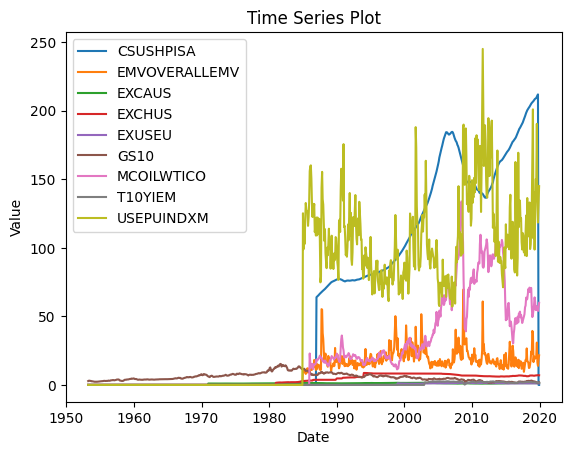

In [43]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))

for column in df_total.columns:
    if df_total[column].dtype in [float,int]:
        plt.plot(df_total.index, df_total[column], label=column)
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

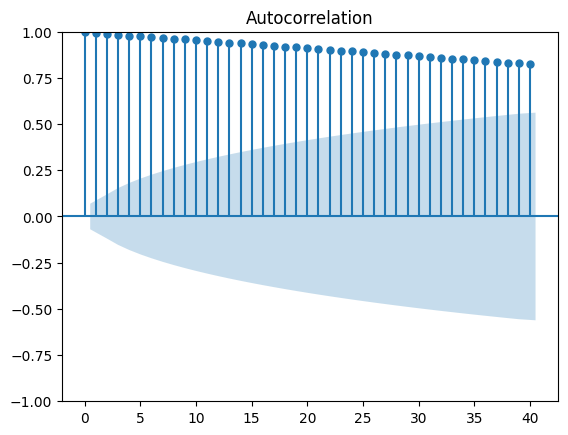

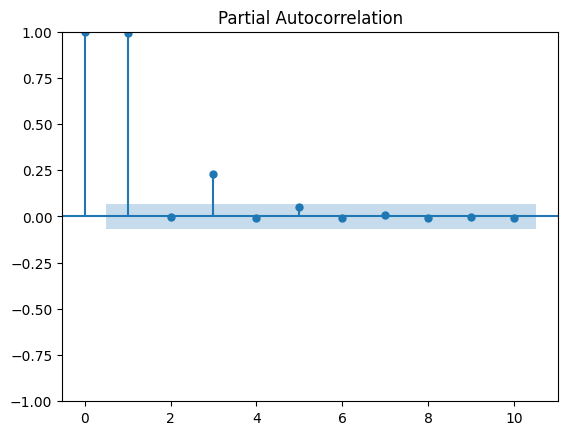

In [91]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_total.iloc[:,0], lags=40) 
plot_pacf(df_total.iloc[:,0], lags=10)

plt.show()

### ADF test for stationarity

In [6]:
from statsmodels.tsa.stattools import adfuller
adf=adfuller(df_total.iloc[:,0])
# test stat, pval < 0.05 then stationary else non stationary

## Modelling

In [ ]:
mod_ses = sm.tsa.statespace.ExponentialSmoothing(df_train)
ses=mod_ses.fit()
forecast_ses=ses.forecast(6)

In [94]:
# for long format


# from autots import AutoTS

# auto_model=AutoTS(3,"infer",max_generations=5,no_negatives=True,ensemble='simple')
# auto_model = auto_model.fit(
#     df_train,date_col='datetime',value_col='value',id_col='series_id'
# )
# prediction=auto_model.predict()
# forecasts_df = prediction.forecast

In [11]:
long=False
from autots import AutoTS

model = AutoTS(
    forecast_length=6,
    frequency='infer',
    prediction_interval=0.9,
    ensemble='horizontal',
    model_list="multivariate",  # "superfast", "default", "fast_parallel"
    transformer_list="fast",  # "superfast",
    max_generations=4,
    num_validations=2,
    validation_method="backwards"
)
model.fit(
    df_train,
    date_col='datetime' if long else None,
    value_col='value' if long else None,
    id_col='series_id' if long else None,
)

prediction = model.predict()

Data frequency is: MS, used frequency is: MS
Model Number: 1 with model GluonTS in generation 0 of 4
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue, try 1.23.1 {as of 06-2023}') in model 1 in generation 0: GluonTS
Model Number: 2 with model GluonTS in generation 0 of 4
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue, try 1.23.1 {as of 06-2023}') in model 2 in generation 0: GluonTS
Model Number: 3 with model GluonTS in generation 0 of 4
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue, try 1.23.1 {as of 06-2023}') in model 3 in generation 0: GluonTS
Model Number: 4 with model GluonTS in generation 0 of 4
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue, try 1.23.1 {as of 06-2023}') in 

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 11 with model GluonTS in generation 0 of 4
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue, try 1.23.1 {as of 06-2023}') in model 11 in generation 0: GluonTS
Model Number: 12 with model MultivariateRegression in generation 0 of 4
Model Number: 13 with model MultivariateRegression in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 13 in generation 0: MultivariateRegression
Model Number: 14 with model VECM in generation 0 of 4
Model Number: 15 with model MultivariateMotif in generation 0 of 4
Model Number: 16 with model MultivariateMotif in generation 0 of 4
Model Number: 17 with model SectionalMotif in generation 0 of 4
Model Number: 18 with model SectionalMotif in generation 0 of 4
Model Number: 19 with model MultivariateRegression in generation 0 of 4
Model Number: 20 with model NVAR in generation 0 of 4
Model Number: 21 wit

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but ExtraTreesRe

Model Number: 24 with model Cassandra in generation 0 of 4
Model Number: 25 with model TiDE in generation 0 of 4
Template Eval Error: NameError("name 'tf' is not defined") in model 25 in generation 0: TiDE
Model Number: 26 with model Cassandra in generation 0 of 4
Model Number: 27 with model Cassandra in generation 0 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 28 with model NeuralForecast in generation 0 of 4
Template Eval Error: ModuleNotFoundError("No module named 'neuralforecast'") in model 28 in generation 0: NeuralForecast
Model Number: 29 with model VECM in generation 0 of 4
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 29 in generation 0: VECM
Model Number: 30 with model DynamicFactor in generation 0 of 4
Template Eval Error: ValueError('Number of factors must be less than the number of endogenous variables.') in model 30 in generation 0: DynamicFactor
Model Number: 31 with model GluonTS in generation 0 of 4
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue, try 1.23.1 {as of 06-2023}') in model 31 in generation 0: GluonTS
Model Number: 32 with model RollingRegression in generation 0 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPRegress

Model Number: 33 with model WindowRegression in generation 0 of 4


[LightGBM] [Fatal] [gamma]: at least one target label is negative
[LightGBM] [Fatal] [gamma]: at least one target label is negative
[LightGBM] [Fatal] [gamma]: at least one target label is negative
[LightGBM] [Fatal] [gamma]: at least one target label is negative
[LightGBM] [Fatal] [gamma]: at least one target label is negative
[LightGBM] [Fatal] [gamma]: at least one target label is negative
[LightGBM] [Fatal] [gamma]: at least one target label is negative


Template Eval Error: LightGBMError('[gamma]: at least one target label is negative') in model 33 in generation 0: WindowRegression
Model Number: 34 with model VAR in generation 0 of 4
Model Number: 35 with model MultivariateMotif in generation 0 of 4
Model Number: 36 with model NVAR in generation 0 of 4
Model Number: 37 with model MultivariateRegression in generation 0 of 4
Model Number: 38 with model SectionalMotif in generation 0 of 4
Model Number: 39 with model DynamicFactorMQ in generation 0 of 4
Template Eval Error: Exception('Transformer MaxAbsScaler failed on fit') in model 39 in generation 0: DynamicFactorMQ
Model Number: 40 with model PytorchForecasting in generation 0 of 4
Template Eval Error: ImportError('pytorch, pytorch lighting, or pytorch-forecasting not present') in model 40 in generation 0: PytorchForecasting
Model Number: 41 with model RRVAR in generation 0 of 4
Model Number: 42 with model MAR in generation 0 of 4
Model Number: 43 with model TMF in generation 0 of 4
T

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.3669e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.3669e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 51 with model VAR in generation 0 of 4
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 51 in generation 0: VAR
Model Number: 52 with model NeuralForecast in generation 0 of 4
Template Eval Error: ModuleNotFoundError("No module named 'neuralforecast'") in model 52 in generation 0: NeuralForecast
Model Number: 53 with model LATC in generation 0 of 4
Model Number: 54 with model MultivariateRegression in generation 0 of 4
Model Number: 55 with model BallTreeMultivariateMotif in generation 0 of 4
Template Eval Error: ValueError("Unrecognized metric '['euclidean']'") in model 55 in generation 0: BallTreeMultivariateMotif
Model Number: 56 with model VECM in generation 0 of 4
Model Number: 57 with model MultivariateRegression in generation 0 of 4
Model Number: 58 with model MultivariateRegression in generation 0 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 59 with model Cassandra in generation 0 of 4
Model Number: 60 with model DynamicFactor in generation 0 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Number: 61 with model RollingRegression in generation 0 of 4
Model Number: 62 with model SectionalMotif in generation 0 of 4
Model Number: 63 with model VAR in generation 0 of 4
Model Number: 64 with model VAR in generation 0 of 4
Model Number: 65 with model Cassandra in generation 0 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MultiTaskElasticNet was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MultiTaskElasticNet was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MultiTaskElasticNet was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MultiTaskElasticNet was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MultiTaskEla

Model Number: 66 with model MultivariateMotif in generation 0 of 4
Model Number: 67 with model RollingRegression in generation 0 of 4
Template Eval Error: ValueError('future_regressor not supplied, necessary for regression_type') in model 67 in generation 0: RollingRegression
Model Number: 68 with model VECM in generation 0 of 4
Model Number: 69 with model BallTreeMultivariateMotif in generation 0 of 4
Template Eval Error: ValueError("Unrecognized metric '['kdtree']'") in model 69 in generation 0: BallTreeMultivariateMotif
Model Number: 70 with model VAR in generation 0 of 4
Template Eval Error: IndexError('tuple index out of range') in model 70 in generation 0: VAR
Model Number: 71 with model RollingRegression in generation 0 of 4
Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'fake_date', 'transformations': {'0': 'Round', '1': 'Log', '2': 'AlignLastValue', '3': 'RobustScaler', '4': 'CumSumTransformer', '5': 'QuantileTransformer'}, 't

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecastin

Model Number: 75 with model Cassandra in generation 0 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 76 with model MAR in generation 0 of 4
Model Number: 77 with model RollingRegression in generation 0 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitl

Model Number: 78 with model SectionalMotif in generation 0 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.w

Model Number: 79 with model MultivariateMotif in generation 0 of 4
Model Number: 80 with model LATC in generation 0 of 4
Model Number: 81 with model MultivariateRegression in generation 0 of 4
Model Number: 82 with model SectionalMotif in generation 0 of 4
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 82 in generation 0: SectionalMotif
Model Number: 83 with model PytorchForecasting in generation 0 of 4
Template Eval Error: ImportError('pytorch, pytorch lighting, or pytorch-forecasting not present') in model 83 in generation 0: PytorchForecasting
Model Number: 84 with model MultivariateMotif in generation 0 of 4
Model Number: 85 with model DynamicFactorMQ in generation 0 of 4
Model Number: 86 with model RRVAR in generation 0 of 4
Template Eval Error: Exception('Transformer KalmanSmoothing failed on fit') in model 86 in generation 0: RRVAR
Model Number: 87 with model MAR in generation 0 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.3669e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 88 with model MAR in generation 0 of 4
Model Number: 89 with model MAR in generation 0 of 4
Model Number: 90 with model RollingRegression in generation 0 of 4
Template Eval Error: LightGBMError('Check failed: (label) > (0) at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_87xzjhjsx9/croot/lightgbm_1700267949723/work/src/metric/regression_metric.hpp, line 274 .\n') in model 90 in generation 0: RollingRegression
Model Number: 91 with model RollingRegression in generation 0 of 4


[LightGBM] [Fatal] Check failed: (label) > (0) at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_87xzjhjsx9/croot/lightgbm_1700267949723/work/src/metric/regression_metric.hpp, line 274 .

[LightGBM] [Fatal] Check failed: (label) > (0) at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_87xzjhjsx9/croot/lightgbm_1700267949723/work/src/metric/regression_metric.hpp, line 274 .

[LightGBM] [Fatal] Check failed: (label) > (0) at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_87xzjhjsx9/croot/lightgbm_1700267949723/work/src/metric/regression_metric.hpp, line 274 .

[LightGBM] [Fatal] Check failed: (label) > (0) at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_87xzjhjsx9/croot/lightgbm_1700267949723/work/src/metric/regression_metric.hpp, line 274 .

[LightGBM] [Fatal] Check failed: (label) > (0) at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_87xzjhjsx9/croot/lightgbm_1700267949723/work/src/metric/regression_metric.hpp, li

Model Number: 92 with model DynamicFactorMQ in generation 0 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1950: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('0.1', '0.2'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'


Model Number: 93 with model Cassandra in generation 0 of 4
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 93 in generation 0: Cassandra
Model Number: 94 with model MultivariateRegression in generation 0 of 4
Model Number: 95 with model SectionalMotif in generation 0 of 4
Model Number: 96 with model LATC in generation 0 of 4
Model Number: 97 with model RRVAR in generation 0 of 4
Model Number: 98 with model BallTreeMultivariateMotif in generation 0 of 4
Template Eval Error: ValueError("Unrecognized metric '['minkowski']'") in model 98 in generation 0: BallTreeMultivariateMotif
Model Number: 99 with model DynamicFactorMQ in generation 0 of 4
Model Number: 100 with model NeuralForecast in generation 0 of 4
Template Eval Error: ModuleNotFoundError("No module named 'neuralforecast'") in model 100 in generation 0: NeuralForecast
Model Number: 101 with model MultivariateMotif in generation 0 of 4
Model Number: 102 with model VECM in generation 0 of 4
Model Num

[LightGBM] [Fatal] Check failed: (label) > (0) at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_87xzjhjsx9/croot/lightgbm_1700267949723/work/src/metric/regression_metric.hpp, line 274 .



Model Number: 107 with model DynamicFactorMQ in generation 0 of 4
Model Number: 108 with model MAR in generation 0 of 4
Model Number: 109 with model DynamicFactorMQ in generation 0 of 4
Template Eval Error: ValueError('Number of factors (10) cannot be greater than the number of monthly endogenous variables (9).') in model 109 in generation 0: DynamicFactorMQ
Model Number: 110 with model TMF in generation 0 of 4
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 110 in generation 0: TMF
Model Number: 111 with model PytorchForecasting in generation 0 of 4
Template Eval Error: ImportError('pytorch, pytorch lighting, or pytorch-forecasting not present') in model 111 in generation 0: PytorchForecasting
Model Number: 112 with model NVAR in generation 0 of 4
Model Number: 113 with model GluonTS in generation 0 of 4
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue, try 1.23.1 {as of 06-202

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2691: UserWarning: EM reached maximum number of iterations (1000), without achieving convergence: llf=908, convergence criterion=6.3249e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


Model Number: 115 with model MultivariateRegression in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 115 in generation 0: MultivariateRegression
Model Number: 116 with model MultivariateMotif in generation 0 of 4
Model Number: 117 with model VAR in generation 0 of 4
Model Number: 118 with model MultivariateRegression in generation 0 of 4
Template Eval Error: ValueError('array must not contain infs or NaNs') in model 118 in generation 0: MultivariateRegression
Model Number: 119 with model DynamicFactorMQ in generation 0 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Model Number: 120 with model NVAR in generation 0 of 4
Model Number: 121 with model MAR in generation 0 of 4
Model Number: 122 with model BallTreeMultivariateMotif in generation 0 of 4
Template Eval Error: ValueError("Unrecognized metric '['euclidean']'") in model 122 in generation 0: BallTreeMultivariateMotif
Model Number: 123 with model MultivariateMotif in generation 0 of 4
Model Number: 124 with model TiDE in generation 0 of 4
Template Eval Error: NameError("name 'tf' is not defined") in model 124 in generation 0: TiDE
Model Number: 125 with model NeuralForecast in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 125 in generation 0: NeuralForecast
Model Number: 126 with model TMF in generation 0 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/autots/models/matrix_var.py:379: RuntimeWarning: invalid value encountered in scalar divide
  alpha = rold / np.inner(q, Aq)


Template Eval Error: LinAlgError('SVD did not converge') in model 126 in generation 0: TMF
Model Number: 127 with model LATC in generation 0 of 4
Template Eval Error: ValueError('negative dimensions are not allowed') in model 127 in generation 0: LATC
Model Number: 128 with model WindowRegression in generation 0 of 4
New Generation: 1 of 4
Model Number: 129 with model WindowRegression in generation 1 of 4
Model Number: 130 with model MultivariateRegression in generation 1 of 4
Model Number: 131 with model VAR in generation 1 of 4
Model Number: 132 with model NVAR in generation 1 of 4
Model Number: 133 with model NVAR in generation 1 of 4
Model Number: 134 with model RollingRegression in generation 1 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitl

Model Number: 135 with model NVAR in generation 1 of 4
Template Eval Error: ValueError('Model NVAR returned NaN for one or more series. fail_on_forecast_nan=True') in model 135 in generation 1: NVAR
Model Number: 136 with model RollingRegression in generation 1 of 4
Model Number: 137 with model DynamicFactorMQ in generation 1 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MultiTaskElasticNet was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MultiTaskElasticNet was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MultiTaskElasticNet was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MultiTaskElasticNet was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MultiTaskEla

Model Number: 138 with model VAR in generation 1 of 4
Template Eval Error: IndexError('tuple index out of range') in model 138 in generation 1: VAR
Model Number: 139 with model VECM in generation 1 of 4
Model Number: 140 with model VECM in generation 1 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2691: UserWarning: EM reached maximum number of iterations (1000), without achieving convergence: llf=-982.33, convergence criterion=2.4553e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


Model Number: 141 with model LATC in generation 1 of 4
Model Number: 142 with model SectionalMotif in generation 1 of 4
Model Number: 143 with model RollingRegression in generation 1 of 4
Model Number: 144 with model VAR in generation 1 of 4
Model Number: 145 with model WindowRegression in generation 1 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 146 with model LATC in generation 1 of 4
Template Eval Error: ValueError('LATC cannot accept any arrays that are all 0') in model 146 in generation 1: LATC
Model Number: 147 with model MAR in generation 1 of 4
Model Number: 148 with model Cassandra in generation 1 of 4
Model Number: 149 with model RollingRegression in generation 1 of 4
Template Eval Error: ValueError('future_regressor not supplied, necessary for regression_type') in model 149 in generation 1: RollingRegression
Model Number: 150 with model VECM in generation 1 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 151 with model DynamicFactorMQ in generation 1 of 4
Model Number: 152 with model DynamicFactor in generation 1 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Number: 153 with model SectionalMotif in generation 1 of 4
Model Number: 154 with model VAR in generation 1 of 4
Model Number: 155 with model RollingRegression in generation 1 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitl

Model Number: 156 with model SectionalMotif in generation 1 of 4
Model Number: 157 with model Cassandra in generation 1 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.w

Model Number: 158 with model DynamicFactorMQ in generation 1 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1950: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('0.1', '0.2'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'


Model Number: 159 with model MultivariateMotif in generation 1 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2691: UserWarning: EM reached maximum number of iterations (1000), without achieving convergence: llf=4790.9, convergence criterion=4.5512e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


Model Number: 160 with model VAR in generation 1 of 4
Model Number: 161 with model VECM in generation 1 of 4
Model Number: 162 with model DynamicFactorMQ in generation 1 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Model Number: 163 with model SectionalMotif in generation 1 of 4
Model Number: 164 with model MultivariateRegression in generation 1 of 4
Model Number: 165 with model MultivariateRegression in generation 1 of 4
Model Number: 166 with model MultivariateRegression in generation 1 of 4
Model Number: 167 with model NVAR in generation 1 of 4
Model Number: 168 with model Cassandra in generation 1 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 169 with model MultivariateMotif in generation 1 of 4
Model Number: 170 with model LATC in generation 1 of 4
Model Number: 171 with model VECM in generation 1 of 4
Model Number: 172 with model Cassandra in generation 1 of 4
Model Number: 173 with model MAR in generation 1 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.3669e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 174 with model DynamicFactorMQ in generation 1 of 4
Model Number: 175 with model MultivariateMotif in generation 1 of 4
Model Number: 176 with model RollingRegression in generation 1 of 4
Model Number: 177 with model VAR in generation 1 of 4
Model Number: 178 with model Cassandra in generation 1 of 4
Model Number: 179 with model MultivariateRegression in generation 1 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 180 with model NVAR in generation 1 of 4
Model Number: 181 with model VAR in generation 1 of 4
Model Number: 182 with model SectionalMotif in generation 1 of 4
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 182 in generation 1: SectionalMotif
Model Number: 183 with model LATC in generation 1 of 4
Model Number: 184 with model RRVAR in generation 1 of 4
Model Number: 185 with model MAR in generation 1 of 4
Model Number: 186 with model MultivariateMotif in generation 1 of 4
Model Number: 187 with model MultivariateMotif in generation 1 of 4
Model Number: 188 with model MultivariateRegression in generation 1 of 4
Model Number: 189 with model Cassandra in generation 1 of 4
Model Number: 190 with model VECM in generation 1 of 4
Model Number: 191 with model SectionalMotif in generation 1 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.3669e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 192 with model MAR in generation 1 of 4
Model Number: 193 with model MAR in generation 1 of 4
Model Number: 194 with model VECM in generation 1 of 4
Model Number: 195 with model DynamicFactorMQ in generation 1 of 4
Model Number: 196 with model SectionalMotif in generation 1 of 4
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 196 in generation 1: SectionalMotif
Model Number: 197 with model VECM in generation 1 of 4
Model Number: 198 with model MultivariateMotif in generation 1 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2691: UserWarning: EM reached maximum number of iterations (1000), without achieving convergence: llf=-2990.8, convergence criterion=1.7277e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


Model Number: 199 with model MultivariateRegression in generation 1 of 4
Model Number: 200 with model MAR in generation 1 of 4
Model Number: 201 with model RollingRegression in generation 1 of 4
Model Number: 202 with model MultivariateMotif in generation 1 of 4
Model Number: 203 with model MultivariateRegression in generation 1 of 4
Model Number: 204 with model DynamicFactorMQ in generation 1 of 4
Model Number: 205 with model VAR in generation 1 of 4
Model Number: 206 with model SectionalMotif in generation 1 of 4
Model Number: 207 with model VECM in generation 1 of 4
Model Number: 208 with model VECM in generation 1 of 4
Model Number: 209 with model MultivariateMotif in generation 1 of 4
Model Number: 210 with model RRVAR in generation 1 of 4
Model Number: 211 with model VAR in generation 1 of 4
Model Number: 212 with model LATC in generation 1 of 4
Model Number: 213 with model LATC in generation 1 of 4
Template Eval Error: ValueError('LATC cannot accept any arrays that are all 0') i

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Template Eval Error: AttributeError("'numpy.ndarray' object has no attribute 'values'") in model 238 in generation 2: DynamicFactor
Model Number: 239 with model VECM in generation 2 of 4
Model Number: 240 with model VECM in generation 2 of 4
Model Number: 241 with model MultivariateMotif in generation 2 of 4
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 241 in generation 2: MultivariateMotif
Model Number: 242 with model Cassandra in generation 2 of 4
Model Number: 243 with model SectionalMotif in generation 2 of 4
Model Number: 244 with model SectionalMotif in generation 2 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.3669e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 245 with model VAR in generation 2 of 4
Model Number: 246 with model MultivariateRegression in generation 2 of 4
Model Number: 247 with model SectionalMotif in generation 2 of 4
Model Number: 248 with model NVAR in generation 2 of 4
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 248 in generation 2: NVAR
Model Number: 249 with model VAR in generation 2 of 4
Model Number: 250 with model MultivariateRegression in generation 2 of 4
Model Number: 251 with model SectionalMotif in generation 2 of 4
Model Number: 252 with model MultivariateRegression in generation 2 of 4
Model Number: 253 with model MAR in generation 2 of 4
Model Number: 254 with model DynamicFactorMQ in generation 2 of 4
Model Number: 255 with model VAR in generation 2 of 4
Model Number: 256 with model Cassandra in generation 2 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2691: UserWarning: EM reached maximum number of iterations (1000), without achieving convergence: llf=-8806.2, convergence criterion=3.7128e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 256 in generation 2: Cassandra
Model Number: 257 with model WindowRegression in generation 2 of 4
Model Number: 258 with model MultivariateMotif in generation 2 of 4
Model Number: 259 with model VAR in generation 2 of 4
Model Number: 260 with model RRVAR in generation 2 of 4
Model Number: 261 with model NVAR in generation 2 of 4
Model Number: 262 with model MultivariateMotif in generation 2 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 263 with model NVAR in generation 2 of 4
Model Number: 264 with model VECM in generation 2 of 4
Model Number: 265 with model MultivariateRegression in generation 2 of 4
Template Eval Error: ValueError('Input X contains NaN.\nRandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values') in model 265 in generation 2: MultivariateRegression
Model Number: 266 with model MultivariateMotif in generation 2 of 4
Model Number: 26

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1950: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('0.1', '0.2'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'


Model Number: 268 with model LATC in generation 2 of 4
Model Number: 269 with model LATC in generation 2 of 4
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 269 in generation 2: LATC
Model Number: 270 with model MultivariateMotif in generation 2 of 4
Model Number: 271 with model DynamicFactor in generation 2 of 4
Template Eval Error: ValueError('Number of factors must be less than the number of endogenous variables.') in model 271 in generation 2: DynamicFactor
Model Number: 272 with model LATC in generation 2 of 4
Model Number: 273 with model WindowRegression in generation 2 of 4
Model Number: 274 with model VECM in generation 2 of 4
Model Number: 275 with model VECM in generation 2 of 4
Model Number: 276 with model RRVAR in generation 2 of 4
Model Number: 277 with model VECM in generation 2 of 4
Model Number: 278 with model VAR in generation 2 of 4
Model Number: 279 with model SectionalMotif in generation 2 of 4
Model Number: 280 with model NVAR in g

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but AdaBoostRegressor wa

Model Number: 292 with model DynamicFactorMQ in generation 2 of 4
Model Number: 293 with model NVAR in generation 2 of 4
Model Number: 294 with model RollingRegression in generation 2 of 4
Model Number: 295 with model DynamicFactorMQ in generation 2 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MultiTaskElasticNet was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MultiTaskElasticNet was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MultiTaskElasticNet was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MultiTaskElasticNet was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MultiTaskEla

Model Number: 296 with model Cassandra in generation 2 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 297 with model LATC in generation 2 of 4
Model Number: 298 with model NVAR in generation 2 of 4
Model Number: 299 with model VAR in generation 2 of 4
Model Number: 300 with model SectionalMotif in generation 2 of 4
Model Number: 301 with model VAR in generation 2 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.3669e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 302 with model DynamicFactorMQ in generation 2 of 4
Model Number: 303 with model SectionalMotif in generation 2 of 4
Model Number: 304 with model VAR in generation 2 of 4
Model Number: 305 with model NVAR in generation 2 of 4
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 305 in generation 2: NVAR
Model Number: 306 with model Cassandra in generation 2 of 4
Model Number: 307 with model VAR in generation 2 of 4
Template Eval Error: ValueError("x contains one or more constant columns. Column(s) 7 are constant. Adding a constant with trend='c' is not allowed.") in model 307 in generation 2: VAR
Model Number: 308 with model NVAR in generation 2 of 4
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 308 in generation 2: NVAR
Model Number: 309 with model DynamicFactorMQ in generation 2 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/autots/tools/impute.py:54: RuntimeWarning: Mean of empty slice
  arr = np.nan_to_num(arr) + np.isnan(arr) * np.nan_to_num(np.nanmean(arr, axis=0))


Model Number: 310 with model RollingRegression in generation 2 of 4
Template Eval Error: ValueError('future_regressor not supplied, necessary for regression_type') in model 310 in generation 2: RollingRegression
Model Number: 311 with model RRVAR in generation 2 of 4
Model Number: 312 with model NVAR in generation 2 of 4
Model Number: 313 with model MAR in generation 2 of 4
Model Number: 314 with model MultivariateRegression in generation 2 of 4
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 314 in generation 2: MultivariateRegression
Model Number: 315 with model DynamicFactorMQ in generation 2 of 4
Model Number: 316 with model DynamicFactorMQ in generation 2 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2691: UserWarning: EM reached maximum number of iterations (1000), without achieving convergence: llf=6312.1, convergence criterion=3.8412e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


Model Number: 317 with model VAR in generation 2 of 4
Model Number: 318 with model DynamicFactorMQ in generation 2 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1950: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('0.1', '0.2'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'


Model Number: 319 with model SectionalMotif in generation 2 of 4
Model Number: 320 with model Cassandra in generation 2 of 4
Template Eval Error: LinAlgError('Singular matrix') in model 320 in generation 2: Cassandra
Model Number: 321 with model VECM in generation 2 of 4
Model Number: 322 with model RollingRegression in generation 2 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default 

Model Number: 323 with model DynamicFactorMQ in generation 2 of 4
Model Number: 324 with model WindowRegression in generation 2 of 4
Model Number: 325 with model SectionalMotif in generation 2 of 4
Model Number: 326 with model VECM in generation 2 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1950: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('0.1', '0.2'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'


Model Number: 327 with model DynamicFactorMQ in generation 2 of 4
Model Number: 328 with model Cassandra in generation 2 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


New Generation: 3 of 4
Model Number: 329 with model DynamicFactorMQ in generation 3 of 4
Model Number: 330 with model VECM in generation 3 of 4
Model Number: 331 with model VECM in generation 3 of 4
Model Number: 332 with model DynamicFactorMQ in generation 3 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1950: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('0.1', '0.2'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'


Model Number: 333 with model MultivariateMotif in generation 3 of 4
Model Number: 334 with model NVAR in generation 3 of 4
Model Number: 335 with model MultivariateRegression in generation 3 of 4
Model Number: 336 with model MultivariateRegression in generation 3 of 4
Model Number: 337 with model Cassandra in generation 3 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 337 in generation 3: Cassandra
Model Number: 338 with model MAR in generation 3 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 339 with model LATC in generation 3 of 4
Model Number: 340 with model Cassandra in generation 3 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 341 with model DynamicFactorMQ in generation 3 of 4
Model Number: 342 with model DynamicFactorMQ in generation 3 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1950: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('0.1', '0.2'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'


Model Number: 343 with model VAR in generation 3 of 4
Model Number: 344 with model RollingRegression in generation 3 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitl

Model Number: 345 with model RRVAR in generation 3 of 4
Model Number: 346 with model NVAR in generation 3 of 4
Model Number: 347 with model VECM in generation 3 of 4
Model Number: 348 with model VAR in generation 3 of 4
Model Number: 349 with model MultivariateMotif in generation 3 of 4
Model Number: 350 with model MAR in generation 3 of 4
Model Number: 351 with model NVAR in generation 3 of 4
Model Number: 352 with model MAR in generation 3 of 4
Model Number: 353 with model LATC in generation 3 of 4
Model Number: 354 with model MultivariateMotif in generation 3 of 4
Model Number: 355 with model MAR in generation 3 of 4
Model Number: 356 with model NVAR in generation 3 of 4
Model Number: 357 with model Cassandra in generation 3 of 4
Model Number: 358 with model MultivariateRegression in generation 3 of 4
Model Number: 359 with model VECM in generation 3 of 4
Model Number: 360 with model SectionalMotif in generation 3 of 4
Model Number: 361 with model VECM in generation 3 of 4
Model Num

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 369 with model VAR in generation 3 of 4
Model Number: 370 with model MAR in generation 3 of 4
Model Number: 371 with model SectionalMotif in generation 3 of 4
Model Number: 372 with model VAR in generation 3 of 4
Model Number: 373 with model MultivariateMotif in generation 3 of 4
Model Number: 374 with model NVAR in generation 3 of 4
Model Number: 375 with model DynamicFactorMQ in generation 3 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1950: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('0.1', '0.2'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'


Model Number: 376 with model LATC in generation 3 of 4
Model Number: 377 with model DynamicFactorMQ in generation 3 of 4
Model Number: 378 with model LATC in generation 3 of 4
Model Number: 379 with model DynamicFactorMQ in generation 3 of 4
Model Number: 380 with model NVAR in generation 3 of 4
Model Number: 381 with model RollingRegression in generation 3 of 4
Template Eval Error: ValueError('future_regressor not supplied, necessary for regression_type') in model 381 in generation 3: RollingRegression
Model Number: 382 with model SectionalMotif in generation 3 of 4
Model Number: 383 with model MultivariateRegression in generation 3 of 4
Model Number: 384 with model SectionalMotif in generation 3 of 4
Model Number: 385 with model NVAR in generation 3 of 4
Model Number: 386 with model MultivariateRegression in generation 3 of 4
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 386 in generation 3: MultivariateRegression
Model Number: 

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 404 with model NVAR in generation 3 of 4
Model Number: 405 with model Cassandra in generation 3 of 4
Model Number: 406 with model NVAR in generation 3 of 4
Model Number: 407 with model VAR in generation 3 of 4
Model Number: 408 with model VECM in generation 3 of 4
Model Number: 409 with model RollingRegression in generation 3 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaco

Model Number: 410 with model LATC in generation 3 of 4
Model Number: 411 with model NVAR in generation 3 of 4
Template Eval Error: Exception('Transformer KalmanSmoothing failed on fit') in model 411 in generation 3: NVAR
Model Number: 412 with model MultivariateMotif in generation 3 of 4
Model Number: 413 with model VECM in generation 3 of 4
Model Number: 414 with model NVAR in generation 3 of 4
Model Number: 415 with model VAR in generation 3 of 4
Model Number: 416 with model RRVAR in generation 3 of 4
Model Number: 417 with model VECM in generation 3 of 4
Model Number: 418 with model RollingRegression in generation 3 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but ExtraTreesRe

Model Number: 419 with model Cassandra in generation 3 of 4
Model Number: 420 with model VAR in generation 3 of 4
Model Number: 421 with model NVAR in generation 3 of 4
Model Number: 422 with model SectionalMotif in generation 3 of 4
Model Number: 423 with model MultivariateRegression in generation 3 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 424 with model Cassandra in generation 3 of 4
Template Eval Error: Exception('Transformer MinMaxScaler failed on fit') in model 424 in generation 3: Cassandra
Model Number: 425 with model VAR in generation 3 of 4
Model Number: 426 with model SectionalMotif in generation 3 of 4
Model Number: 427 with model DynamicFactorMQ in generation 3 of 4
Model Number: 428 with model MAR in generation 3 of 4
New Generation: 4 of 4
Model Number: 429 with model MultivariateRegression in generation 4 of 4
Model Number: 430 with model NVAR in generation 4 of 4
Model Number: 431 with model NVAR in generation 4 of 4
Model Number: 432 with model Cassandra in generation 4 of 4
Model Number: 433 with model NVAR in generation 4 of 4
Model Number: 434 with model VAR in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 435 with model WindowRegression in generation 4 of 4
Model Number: 436 with model NVAR in generation 4 of 4
Model Number: 437 with model MAR in generation 4 of 4
Model Number: 438 with model VAR in generation 4 of 4
Model Number: 439 with model RollingRegression in generation 4 of 4
Model Number: 440 with model Cassandra in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MultiTaskElasticNet was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MultiTaskElasticNet was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MultiTaskElasticNet was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MultiTaskElasticNet was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MultiTaskEla

Model Number: 441 with model LATC in generation 4 of 4
Model Number: 442 with model WindowRegression in generation 4 of 4
Model Number: 443 with model WindowRegression in generation 4 of 4
Model Number: 444 with model NVAR in generation 4 of 4
Model Number: 445 with model VECM in generation 4 of 4
Model Number: 446 with model NVAR in generation 4 of 4
Model Number: 447 with model DynamicFactorMQ in generation 4 of 4
Model Number: 448 with model VAR in generation 4 of 4
Template Eval Error: ValueError('maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.') in model 448 in generation 4: VAR
Model Number: 449 with model NVAR in generation 4 of 4
Model Number: 450 with model Cassandra in generation 4 of 4
Model Number: 451 with model VAR in generation 4 of 4
Template Eval Error: LinAlgError('3-th leading minor of the array is not positive definite') in model 451 in generation 4: VAR
Model Number: 452 with model Multivariate

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Template Eval Error: ValueError('Input X contains NaN.\nExtraTreesRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values') in model 457 in generation 4: MultivariateRegression
Model Number: 458 with model SectionalMotif in generation 4 of 4
Model Number: 459 with model VAR in generation 4 of 4
Model Number: 460 with model RRVAR in generation 4 of 4
Model Number: 461 with model MultivariateRegression in generation 4 of 4
Model Number: 462 wit

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1950: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('0.1', '0.2'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'


Model Number: 468 with model LATC in generation 4 of 4
Model Number: 469 with model MAR in generation 4 of 4
Model Number: 470 with model MultivariateMotif in generation 4 of 4
Model Number: 471 with model DynamicFactorMQ in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Model Number: 472 with model Cassandra in generation 4 of 4
Model Number: 473 with model MultivariateRegression in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 474 with model SectionalMotif in generation 4 of 4
Model Number: 475 with model MAR in generation 4 of 4
Model Number: 476 with model NVAR in generation 4 of 4
Model Number: 477 with model NVAR in generation 4 of 4
Model Number: 478 with model Cassandra in generation 4 of 4
Template Eval Error: IndexError('positional indexers are out-of-bounds') in model 478 in generation 4: Cassandra
Model Number: 479 with model SectionalMotif in generation 4 of 4
Model Number: 480 with model VAR in generation 4 of 4
Model Number: 481 with model RollingRegression in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitl

Model Number: 482 with model SectionalMotif in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.w

Model Number: 483 with model MultivariateMotif in generation 4 of 4
Model Number: 484 with model MAR in generation 4 of 4
Model Number: 485 with model MAR in generation 4 of 4
Model Number: 486 with model Cassandra in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 487 with model MultivariateMotif in generation 4 of 4
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 487 in generation 4: MultivariateMotif
Model Number: 488 with model VECM in generation 4 of 4
Model Number: 489 with model DynamicFactorMQ in generation 4 of 4
Model Number: 490 with model NVAR in generation 4 of 4
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 490 in generation 4: NVAR
Model Number: 491 with model LATC in generation 4 of 4
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 491 in generation 4: LATC
Model Number: 492 with model VAR in generation 4 of 4
Model Number: 493 with model DynamicFactor in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Number: 494 with model DynamicFactorMQ in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2691: UserWarning: EM reached maximum number of iterations (1000), without achieving convergence: llf=-829.04, convergence criterion=1.9454e-05 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


Model Number: 495 with model Cassandra in generation 4 of 4
Model Number: 496 with model VAR in generation 4 of 4
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 496 in generation 4: VAR
Model Number: 497 with model DynamicFactorMQ in generation 4 of 4
Model Number: 498 with model SectionalMotif in generation 4 of 4
Model Number: 499 with model MultivariateRegression in generation 4 of 4
Model Number: 500 with model DynamicFactorMQ in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1950: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('0.1', '0.2'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'


Model Number: 501 with model VAR in generation 4 of 4
Model Number: 502 with model VECM in generation 4 of 4
Model Number: 503 with model DynamicFactor in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Number: 504 with model DynamicFactorMQ in generation 4 of 4
Model Number: 505 with model VAR in generation 4 of 4
Model Number: 506 with model LATC in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2651: UserWarning: Log-likelihood decreased at EM iteration 2. Reverting to the results from EM iteration 1 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'


Model Number: 507 with model VECM in generation 4 of 4
Model Number: 508 with model DynamicFactorMQ in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1950: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('0.1', '0.2'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Model Number: 509 with model NVAR in generation 4 of 4
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 509 in generation 4: NVAR
Model Number: 510 with model MAR in generation 4 of 4
Model Number: 511 with model LATC in generation 4 of 4
Model Number: 512 with model RRVAR in generation 4 of 4
Model Number: 513 with model WindowRegression in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 514 with model Cassandra in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1950: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('0.1', '0.2'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'


Model Number: 515 with model DynamicFactorMQ in generation 4 of 4
Model Number: 516 with model SectionalMotif in generation 4 of 4
Model Number: 517 with model SectionalMotif in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2691: UserWarning: EM reached maximum number of iterations (1000), without achieving convergence: llf=-1898.2, convergence criterion=3.0762e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.3669e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2651: UserWarning: Log-likelihood decreased at EM iteration 2. Reverting to the results from EM iteration 1 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'


Model Number: 518 with model DynamicFactorMQ in generation 4 of 4
Model Number: 519 with model MAR in generation 4 of 4
Model Number: 520 with model MultivariateRegression in generation 4 of 4
Model Number: 521 with model VECM in generation 4 of 4
Model Number: 522 with model NVAR in generation 4 of 4
Model Number: 523 with model VECM in generation 4 of 4
Model Number: 524 with model MultivariateMotif in generation 4 of 4
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 524 in generation 4: MultivariateMotif
Model Number: 525 with model VAR in generation 4 of 4
Template Eval Error: LinAlgError('3-th leading minor of the array is not positive definite') in model 525 in generation 4: VAR
Model Number: 526 with model Cassandra in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 527 with model MultivariateMotif in generation 4 of 4
Model Number: 528 with model RRVAR in generation 4 of 4
Ensembling Error: NameError("name 'verbose' is not defined"): Traceback (most recent call last):
  File "/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/autots/evaluator/auto_ts.py", line 1311, in fit
    self._run_template(
  File "/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/autots/evaluator/auto_ts.py", line 2024, in _run_template
    if verbose >= 0:
NameError: name 'verbose' is not defined

Validation Round: 1
Model Number: 1 of 90 with model VAR for Validation 1
📈 1 - VAR with avg smape 9.87: 
Model Number: 2 of 90 with model VAR for Validation 1
2 - VAR with avg smape 10.14: 
Model Number: 3 of 90 with model DynamicFactorMQ for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1950: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('0.1', '0.2'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'


📈 3 - DynamicFactorMQ with avg smape 9.76: 
Model Number: 4 of 90 with model DynamicFactorMQ for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1950: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('0.1', '0.2'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'


4 - DynamicFactorMQ with avg smape 9.76: 
Model Number: 5 of 90 with model DynamicFactorMQ for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


5 - DynamicFactorMQ with avg smape 10.44: 
Model Number: 6 of 90 with model VAR for Validation 1
📈 6 - VAR with avg smape 8.37: 
Model Number: 7 of 90 with model VAR for Validation 1
7 - VAR with avg smape 8.37: 
Model Number: 8 of 90 with model NVAR for Validation 1
8 - NVAR with avg smape 8.87: 
Model Number: 9 of 90 with model VAR for Validation 1
9 - VAR with avg smape 14.6: 
Model Number: 10 of 90 with model NVAR for Validation 1
10 - NVAR with avg smape 9.6: 
Model Number: 11 of 90 with model NVAR for Validation 1
11 - NVAR with avg smape 9.6: 
Model Number: 12 of 90 with model NVAR for Validation 1
12 - NVAR with avg smape 9.6: 
Model Number: 13 of 90 with model NVAR for Validation 1
13 - NVAR with avg smape 9.46: 
Model Number: 14 of 90 with model LATC for Validation 1
14 - LATC with avg smape 13.79: 
Model Number: 15 of 90 with model DynamicFactorMQ for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1950: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('0.1', '0.2'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'


15 - DynamicFactorMQ with avg smape 8.59: 
Model Number: 16 of 90 with model DynamicFactorMQ for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


16 - DynamicFactorMQ with avg smape 10.45: 
Model Number: 17 of 90 with model SectionalMotif for Validation 1
17 - SectionalMotif with avg smape 10.79: 
Model Number: 18 of 90 with model LATC for Validation 1
18 - LATC with avg smape 9.19: 
Model Number: 19 of 90 with model LATC for Validation 1
19 - LATC with avg smape 9.19: 
Model Number: 20 of 90 with model SectionalMotif for Validation 1
20 - SectionalMotif with avg smape 9.9: 
Model Number: 21 of 90 with model SectionalMotif for Validation 1
21 - SectionalMotif with avg smape 13.26: 
Model Number: 22 of 90 with model Cassandra for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


22 - Cassandra with avg smape 10.89: 
Model Number: 23 of 90 with model LATC for Validation 1
23 - LATC with avg smape 11.32: 
Model Number: 24 of 90 with model Cassandra for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


24 - Cassandra with avg smape 10.62: 
Model Number: 25 of 90 with model MultivariateRegression for Validation 1
📈 25 - MultivariateRegression with avg smape 8.28: 
Model Number: 26 of 90 with model MAR for Validation 1
26 - MAR with avg smape 9.96: 
Model Number: 27 of 90 with model MAR for Validation 1
27 - MAR with avg smape 12.4: 
Model Number: 28 of 90 with model MultivariateRegression for Validation 1
28 - MultivariateRegression with avg smape 9.3: 
Model Number: 29 of 90 with model MultivariateMotif for Validation 1
29 - MultivariateMotif with avg smape 8.94: 
Model Number: 30 of 90 with model MultivariateMotif for Validation 1
30 - MultivariateMotif with avg smape 8.97: 
Model Number: 31 of 90 with model VECM for Validation 1
31 - VECM with avg smape 8.36: 
Model Number: 32 of 90 with model SectionalMotif for Validation 1
32 - SectionalMotif with avg smape 16.56: 
Model Number: 33 of 90 with model VECM for Validation 1
33 - VECM with avg smape 11.69: 
Model Number: 34 of 90 with

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


36 - VECM with avg smape 11.59: 
Model Number: 37 of 90 with model MultivariateRegression for Validation 1
37 - MultivariateRegression with avg smape 8.81: 
Model Number: 38 of 90 with model SectionalMotif for Validation 1
38 - SectionalMotif with avg smape 14.43: 
Model Number: 39 of 90 with model MultivariateRegression for Validation 1
39 - MultivariateRegression with avg smape 9.64: 
Model Number: 40 of 90 with model VECM for Validation 1
40 - VECM with avg smape 11.99: 
Model Number: 41 of 90 with model LATC for Validation 1
41 - LATC with avg smape 10.68: 
Model Number: 42 of 90 with model VECM for Validation 1
42 - VECM with avg smape 14.46: 
Model Number: 43 of 90 with model MultivariateMotif for Validation 1
43 - MultivariateMotif with avg smape 11.03: 
Model Number: 44 of 90 with model MAR for Validation 1
44 - MAR with avg smape 12.09: 
Model Number: 45 of 90 with model RRVAR for Validation 1
45 - RRVAR with avg smape 9.86: 
Model Number: 46 of 90 with model Cassandra for Val

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


48 - Cassandra with avg smape 11.8: 
Model Number: 49 of 90 with model MAR for Validation 1
49 - MAR with avg smape 10.97: 
Model Number: 50 of 90 with model MAR for Validation 1
50 - MAR with avg smape 11.5: 
Model Number: 51 of 90 with model MultivariateMotif for Validation 1
51 - MultivariateMotif with avg smape 8.37: 
Model Number: 52 of 90 with model Cassandra for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


52 - Cassandra with avg smape 10.13: 
Model Number: 53 of 90 with model WindowRegression for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


53 - WindowRegression with avg smape 9.26: 
Model Number: 54 of 90 with model WindowRegression for Validation 1
54 - WindowRegression with avg smape 9.26: 
Model Number: 55 of 90 with model RRVAR for Validation 1
55 - RRVAR with avg smape 9.77: 
Model Number: 56 of 90 with model RollingRegression for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting

56 - RollingRegression with avg smape 10.31: 
Model Number: 57 of 90 with model RollingRegression for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but L

57 - RollingRegression with avg smape 10.15: 
Model Number: 58 of 90 with model WindowRegression for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.w

58 - WindowRegression with avg smape 14.13: 
Model Number: 59 of 90 with model RollingRegression for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but ExtraTreesRe

59 - RollingRegression with avg smape 8.92: 
Model Number: 60 of 90 with model RollingRegression for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitl

60 - RollingRegression with avg smape 10.55: 
Model Number: 61 of 90 with model RollingRegression for Validation 1
61 - RollingRegression with avg smape 9.99: 
Model Number: 62 of 90 with model RRVAR for Validation 1
62 - RRVAR with avg smape 9.61: 
Model Number: 63 of 90 with model WindowRegression for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.w

63 - WindowRegression with avg smape 12.98: 
Model Number: 64 of 90 with model RRVAR for Validation 1
64 - RRVAR with avg smape 11.04: 
Model Number: 65 of 90 with model RRVAR for Validation 1
65 - RRVAR with avg smape 11.04: 
Model Number: 66 of 90 with model DynamicFactor for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


66 - DynamicFactor with avg smape 33.87: 
Model Number: 67 of 90 with model DynamicFactor for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


67 - DynamicFactor with avg smape 118.36: 
Model Number: 68 of 90 with model DynamicFactor for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


68 - DynamicFactor with avg smape 118.36: 
Model Number: 69 of 90 with model DynamicFactor for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


69 - DynamicFactor with avg smape 10.15: 
Model Number: 70 of 90 with model NVAR for Validation 1
70 - NVAR with avg smape 9.65: 
Model Number: 71 of 90 with model VAR for Validation 1
71 - VAR with avg smape 10.41: 
Model Number: 72 of 90 with model VAR for Validation 1
72 - VAR with avg smape 21.51: 
Model Number: 73 of 90 with model NVAR for Validation 1
73 - NVAR with avg smape 8.94: 
Model Number: 74 of 90 with model VECM for Validation 1
74 - VECM with avg smape 8.55: 
Model Number: 75 of 90 with model VAR for Validation 1
75 - VAR with avg smape 9.35: 
Model Number: 76 of 90 with model MultivariateRegression for Validation 1
76 - MultivariateRegression with avg smape 19.05: 
Model Number: 77 of 90 with model SectionalMotif for Validation 1
77 - SectionalMotif with avg smape 15.05: 
Model Number: 78 of 90 with model NVAR for Validation 1
78 - NVAR with avg smape 36.22: 
Model Number: 79 of 90 with model NVAR for Validation 1
79 - NVAR with avg smape 9.01: 
Model Number: 80 of 90 

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


82 - Cassandra with avg smape 8.68: 
Model Number: 83 of 90 with model MultivariateMotif for Validation 1
83 - MultivariateMotif with avg smape 10.06: 
Model Number: 84 of 90 with model VECM for Validation 1
84 - VECM with avg smape 12.57: 
Model Number: 85 of 90 with model NVAR for Validation 1
85 - NVAR with avg smape 11.08: 
Model Number: 86 of 90 with model NVAR for Validation 1
86 - NVAR with avg smape 9.05: 
Model Number: 87 of 90 with model NVAR for Validation 1
87 - NVAR with avg smape 8.69: 
Model Number: 88 of 90 with model NVAR for Validation 1
88 - NVAR with avg smape 8.66: 
Model Number: 89 of 90 with model MultivariateMotif for Validation 1
89 - MultivariateMotif with avg smape 12.11: 
Model Number: 90 of 90 with model DynamicFactorMQ for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1950: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('0.1', '0.2'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


90 - DynamicFactorMQ with avg smape 10.76: 
Validation Round: 2
Model Number: 1 of 90 with model VAR for Validation 2
📈 1 - VAR with avg smape 10.06: 
Model Number: 2 of 90 with model VAR for Validation 2
2 - VAR with avg smape 11.79: 
Model Number: 3 of 90 with model DynamicFactorMQ for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1950: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('0.1', '0.2'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'


📈 3 - DynamicFactorMQ with avg smape 8.94: 
Model Number: 4 of 90 with model DynamicFactorMQ for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1950: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('0.1', '0.2'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'


4 - DynamicFactorMQ with avg smape 8.94: 
Model Number: 5 of 90 with model DynamicFactorMQ for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


5 - DynamicFactorMQ with avg smape 9.2: 
Model Number: 6 of 90 with model VAR for Validation 2
6 - VAR with avg smape 8.97: 
Model Number: 7 of 90 with model VAR for Validation 2
7 - VAR with avg smape 8.97: 
Model Number: 8 of 90 with model NVAR for Validation 2
📈 8 - NVAR with avg smape 8.43: 
Model Number: 9 of 90 with model VAR for Validation 2
9 - VAR with avg smape 15.36: 
Model Number: 10 of 90 with model NVAR for Validation 2
📈 10 - NVAR with avg smape 6.07: 
Model Number: 11 of 90 with model NVAR for Validation 2
11 - NVAR with avg smape 6.07: 
Model Number: 12 of 90 with model NVAR for Validation 2
12 - NVAR with avg smape 6.07: 
Model Number: 13 of 90 with model NVAR for Validation 2
13 - NVAR with avg smape 7.02: 
Model Number: 14 of 90 with model LATC for Validation 2
14 - LATC with avg smape 12.98: 
Model Number: 15 of 90 with model DynamicFactorMQ for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1950: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('0.1', '0.2'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'


15 - DynamicFactorMQ with avg smape 8.36: 
Model Number: 16 of 90 with model DynamicFactorMQ for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


16 - DynamicFactorMQ with avg smape 9.32: 
Model Number: 17 of 90 with model SectionalMotif for Validation 2
17 - SectionalMotif with avg smape 13.02: 
Model Number: 18 of 90 with model LATC for Validation 2
18 - LATC with avg smape 9.59: 
Model Number: 19 of 90 with model LATC for Validation 2
19 - LATC with avg smape 9.59: 
Model Number: 20 of 90 with model SectionalMotif for Validation 2
20 - SectionalMotif with avg smape 12.88: 
Model Number: 21 of 90 with model SectionalMotif for Validation 2
21 - SectionalMotif with avg smape 9.09: 
Model Number: 22 of 90 with model Cassandra for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


22 - Cassandra with avg smape 16.01: 
Model Number: 23 of 90 with model LATC for Validation 2
23 - LATC with avg smape 11.12: 
Model Number: 24 of 90 with model Cassandra for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


24 - Cassandra with avg smape 12.78: 
Model Number: 25 of 90 with model MultivariateRegression for Validation 2
25 - MultivariateRegression with avg smape 8.67: 
Model Number: 26 of 90 with model MAR for Validation 2
26 - MAR with avg smape 7.8: 
Model Number: 27 of 90 with model MAR for Validation 2
27 - MAR with avg smape 7.8: 
Model Number: 28 of 90 with model MultivariateRegression for Validation 2
28 - MultivariateRegression with avg smape 9.75: 
Model Number: 29 of 90 with model MultivariateMotif for Validation 2
29 - MultivariateMotif with avg smape 12.41: 
Model Number: 30 of 90 with model MultivariateMotif for Validation 2
30 - MultivariateMotif with avg smape 12.45: 
Model Number: 31 of 90 with model VECM for Validation 2
31 - VECM with avg smape 8.95: 
Model Number: 32 of 90 with model SectionalMotif for Validation 2
32 - SectionalMotif with avg smape 16.03: 
Model Number: 33 of 90 with model VECM for Validation 2
33 - VECM with avg smape 17.53: 
Model Number: 34 of 90 with 

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


36 - VECM with avg smape 17.31: 
Model Number: 37 of 90 with model MultivariateRegression for Validation 2
37 - MultivariateRegression with avg smape 7.46: 
Model Number: 38 of 90 with model SectionalMotif for Validation 2
38 - SectionalMotif with avg smape 13.23: 
Model Number: 39 of 90 with model MultivariateRegression for Validation 2
39 - MultivariateRegression with avg smape 10.58: 
Model Number: 40 of 90 with model VECM for Validation 2
40 - VECM with avg smape 19.17: 
Model Number: 41 of 90 with model LATC for Validation 2
41 - LATC with avg smape 9.18: 
Model Number: 42 of 90 with model VECM for Validation 2
42 - VECM with avg smape 19.34: 
Model Number: 43 of 90 with model MultivariateMotif for Validation 2
43 - MultivariateMotif with avg smape 8.75: 
Model Number: 44 of 90 with model MAR for Validation 2
44 - MAR with avg smape 8.92: 
Model Number: 45 of 90 with model RRVAR for Validation 2
45 - RRVAR with avg smape 8.18: 
Model Number: 46 of 90 with model Cassandra for Valid

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


48 - Cassandra with avg smape 17.31: 
Model Number: 49 of 90 with model MAR for Validation 2
49 - MAR with avg smape 8.58: 
Model Number: 50 of 90 with model MAR for Validation 2
50 - MAR with avg smape 8.58: 
Model Number: 51 of 90 with model MultivariateMotif for Validation 2
51 - MultivariateMotif with avg smape 13.85: 
Model Number: 52 of 90 with model Cassandra for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


52 - Cassandra with avg smape 8.52: 
Model Number: 53 of 90 with model WindowRegression for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


53 - WindowRegression with avg smape 8.85: 
Model Number: 54 of 90 with model WindowRegression for Validation 2
54 - WindowRegression with avg smape 8.85: 
Model Number: 55 of 90 with model RRVAR for Validation 2
55 - RRVAR with avg smape 8.27: 
Model Number: 56 of 90 with model RollingRegression for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting

56 - RollingRegression with avg smape 9.76: 
Model Number: 57 of 90 with model RollingRegression for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names,

57 - RollingRegression with avg smape 8.51: 
Model Number: 58 of 90 with model WindowRegression for Validation 2
58 - WindowRegression with avg smape 14.75: 
Model Number: 59 of 90 with model RollingRegression for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but ExtraTreesRe

59 - RollingRegression with avg smape 8.75: 
Model Number: 60 of 90 with model RollingRegression for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitl

60 - RollingRegression with avg smape 13.79: 
Model Number: 61 of 90 with model RollingRegression for Validation 2
61 - RollingRegression with avg smape 8.44: 
Model Number: 62 of 90 with model RRVAR for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.w

62 - RRVAR with avg smape 8.05: 
Model Number: 63 of 90 with model WindowRegression for Validation 2
63 - WindowRegression with avg smape 15.75: 
Model Number: 64 of 90 with model RRVAR for Validation 2
64 - RRVAR with avg smape 15.91: 
Model Number: 65 of 90 with model RRVAR for Validation 2
65 - RRVAR with avg smape 15.91: 
Model Number: 66 of 90 with model DynamicFactor for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


66 - DynamicFactor with avg smape 12.38: 
Model Number: 67 of 90 with model DynamicFactor for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


67 - DynamicFactor with avg smape 116.99: 
Model Number: 68 of 90 with model DynamicFactor for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


68 - DynamicFactor with avg smape 116.99: 
Model Number: 69 of 90 with model DynamicFactor for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


69 - DynamicFactor with avg smape 8.51: 
Model Number: 70 of 90 with model NVAR for Validation 2
📈 70 - NVAR with avg smape 6.0: 
Model Number: 71 of 90 with model VAR for Validation 2
71 - VAR with avg smape 9.57: 
Model Number: 72 of 90 with model VAR for Validation 2
72 - VAR with avg smape 10.23: 
Model Number: 73 of 90 with model NVAR for Validation 2
73 - NVAR with avg smape 8.14: 
Model Number: 74 of 90 with model VECM for Validation 2
74 - VECM with avg smape 10.52: 
Model Number: 75 of 90 with model VAR for Validation 2
75 - VAR with avg smape 10.98: 
Model Number: 76 of 90 with model MultivariateRegression for Validation 2
76 - MultivariateRegression with avg smape 14.0: 
Model Number: 77 of 90 with model SectionalMotif for Validation 2
77 - SectionalMotif with avg smape 11.18: 
Model Number: 78 of 90 with model NVAR for Validation 2
78 - NVAR with avg smape 37.93: 
Model Number: 79 of 90 with model NVAR for Validation 2
79 - NVAR with avg smape 8.01: 
Model Number: 80 of 90 

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


82 - Cassandra with avg smape 10.76: 
Model Number: 83 of 90 with model MultivariateMotif for Validation 2
83 - MultivariateMotif with avg smape 8.45: 
Model Number: 84 of 90 with model VECM for Validation 2
84 - VECM with avg smape 10.85: 
Model Number: 85 of 90 with model NVAR for Validation 2
85 - NVAR with avg smape 10.92: 
Model Number: 86 of 90 with model NVAR for Validation 2
86 - NVAR with avg smape 8.65: 
Model Number: 87 of 90 with model NVAR for Validation 2
87 - NVAR with avg smape 8.98: 
Model Number: 88 of 90 with model NVAR for Validation 2
88 - NVAR with avg smape 8.68: 
Model Number: 89 of 90 with model MultivariateMotif for Validation 2
89 - MultivariateMotif with avg smape 7.45: 
Model Number: 90 of 90 with model DynamicFactorMQ for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1950: UserWarning: Non-stationary starting factor autoregressive parameters found for factor block ('0.1', '0.2'). Using zeros as starting parameters.
  warn('Non-stationary starting factor autoregressive'
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


90 - DynamicFactorMQ with avg smape 8.61: 
Post-Validation Ensembling Error: NameError("name 'verbose' is not defined"): Traceback (most recent call last):
  File "/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/autots/evaluator/auto_ts.py", line 1442, in fit
    self._run_template(
  File "/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/autots/evaluator/auto_ts.py", line 2024, in _run_template
    if verbose >= 0:
NameError: name 'verbose' is not defined

Model Number: 1 with model Ensemble in generation 0 of Horizontal Ensembles


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [12]:
print(model)

Initiated AutoTS object with best model: 
Ensemble
{}
{'model_name': 'Horizontal', 'model_count': 4, 'model_metric': 'Score', 'models': {'9a0edf4cc08f0a8e599877213aa39ed4': {'Model': 'NVAR', 'ModelParameters': '{"k": 1, "ridge_param": 0.002, "warmup_pts": 1, "seed_pts": 1, "seed_weighted": null, "batch_size": 5, "batch_method": "input_order"}', 'TransformationParameters': '{"fillna": "ffill", "transformations": {"0": "MinMaxScaler"}, "transformation_params": {"0": {}}}'}, '8b56ab8f8ee97b547964d8287edc7c85': {'Model': 'DynamicFactorMQ', 'ModelParameters': '{"factors": 3, "factor_orders": 3, "factor_multiplicities": null, "idiosyncratic_ar1": true}', 'TransformationParameters': '{"fillna": null, "transformations": {"0": "ClipOutliers", "1": "cffilter", "2": "StandardScaler"}, "transformation_params": {"0": {"method": "clip", "std_threshold": 5, "fillna": null}, "1": {}, "2": {}}}'}, 'bd3952f93eb3e8d5303d8d5a5b31b3dd': {'Model': 'NVAR', 'ModelParameters': '{"k": 2, "ridge_param": 0.002, "

In [13]:
model.results()['Model'].unique()

array(['GluonTS', 'VAR', 'VECM', 'WindowRegression',
       'MultivariateRegression', 'MultivariateMotif', 'SectionalMotif',
       'NVAR', 'RollingRegression', 'DynamicFactor', 'Cassandra', 'TiDE',
       'NeuralForecast', 'DynamicFactorMQ', 'PytorchForecasting', 'RRVAR',
       'MAR', 'TMF', 'LATC', 'BallTreeMultivariateMotif', 'Ensemble'],
      dtype=object)

In [14]:
model.results("validation")

,ID,Model,ModelParameters,TransformationParameters,Ensemble,Runs,smape,mae,rmse,made,...,dwd_weighted,matse_weighted,containment_weighted,contour_weighted,TotalRuntimeSeconds,Score,lowest_series_mape,lowest_series_mape_name,highest_series_mape,highest_series_mape_name
0,006e2ab807a2783c2833fc25609446c9,MultivariateMotif,"{""window"": 10, ""point_method"": ""midhinge"", ""di...","{""fillna"": ""rolling_mean_24"", ""transformations...",0,1,13.89,8.34,9.19,1.10,...,2.39,0.14,0.54,0.67,0.02,33.23,0.51,CSUSHPISA,142.43,EMVOVERALLEMV
1,009b2a98860cf75bece39c242d4d36f3,Cassandra,"{""preprocessing_transformation"": {""fillna"": ""f...","{""fillna"": ""zero"", ""transformations"": {""0"": ""A...",0,1,199.27,8852.51,9096.71,5753.27,...,30078.60,264.06,0.00,0.48,0.10,71487.10,48852.74,T10YIEM,50055.67,GS10
2,028fd7b422b6ee8f59c41d2ecc21c358,SectionalMotif,"{""window"": 5, ""point_method"": ""midhinge"", ""dis...","{""fillna"": ""rolling_mean_24"", ""transformations...",0,1,15.63,7.61,8.71,1.40,...,2.84,0.21,0.59,0.39,0.03,37.28,1.80,EXCAUS,306.24,EMVOVERALLEMV
3,0480f97223f6d5b7f421efc3ac98335a,MultivariateRegression,"{""regression_model"": {""model"": ""RANSAC"", ""mode...","{""fillna"": ""ffill_mean_biased"", ""transformatio...",0,1,18.97,9.63,10.43,1.63,...,2.94,0.23,0.78,0.50,0.20,44.97,5.55,CSUSHPISA,231.96,EMVOVERALLEMV
4,05738121d8897c13e32dbc3d5818af93,LATC,"{""time_horizon"": 2, ""seasonality"": 7, ""time_la...","{""fillna"": ""ffill"", ""transformations"": {""0"": ""...",0,3,10.88,4.95,6.01,1.14,...,2.30,0.10,0.89,0.56,0.05,26.26,2.36,EXCAUS,114.81,EMVOVERALLEMV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,fcb80228deb7e70fe3a3f625f505df73,DynamicFactor,"{""k_factors"": 3, ""factor_order"": 0, ""regressio...","{""fillna"": ""ffill_mean_biased"", ""transformatio...",0,3,116.01,37.79,38.58,10.18,...,52.72,0.72,1.00,0.42,7.54,939.04,22.31,EXCAUS,406.65,T10YIEM
433,fcd779dcd164b162c1b35d643727c286,RollingRegression,"{""regression_model"": {""model"": ""SVM"", ""model_p...","{""fillna"": ""linear"", ""transformations"": {""0"": ...",0,3,12.67,4.50,5.23,1.43,...,2.75,0.10,0.96,0.50,0.33,41.11,2.33,CSUSHPISA,104.28,T10YIEM
434,fcdfe3207da06cda73780f62bad83c62,DynamicFactorMQ,"{""factors"": 1, ""factor_orders"": 3, ""factor_mul...","{""fillna"": null, ""transformations"": {""0"": ""Cli...",0,1,15.53,11.03,12.92,2.91,...,10.75,0.15,0.83,0.43,4.69,60.36,1.57,EXCHUS,90.17,CSUSHPISA
435,fdffc2f5dfff77ae499e3c91d1475eed,RRVAR,"{""method"": ""dmd"", ""rank"": 4, ""maxiter"": 200}","{""fillna"": ""time"", ""transformations"": {""0"": ""H...",0,1,14.72,5.96,7.23,1.78,...,4.00,0.14,0.96,0.56,0.04,61.21,3.68,GS10,84.25,EMVOVERALLEMV


<Axes: title={'center': 'CSUSHPISA with model DynamicFactorMQ'}>

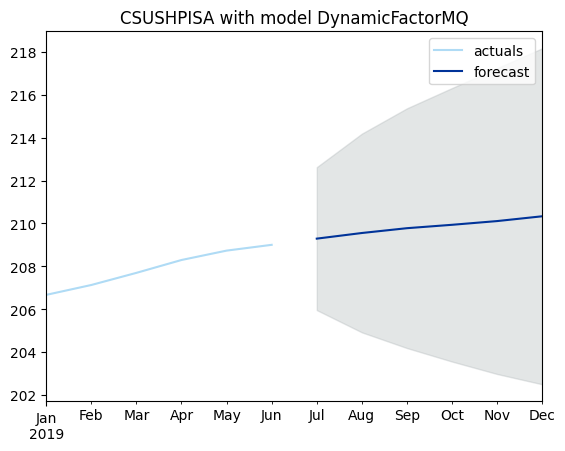

In [15]:
# plot a sample
prediction.plot(model.df_wide_numeric,
                series=model.df_wide_numeric.columns[0],
                start_date="2019-01-01")


In [21]:
# Print the details of the best model
type(model)

autots.evaluator.auto_ts.AutoTS

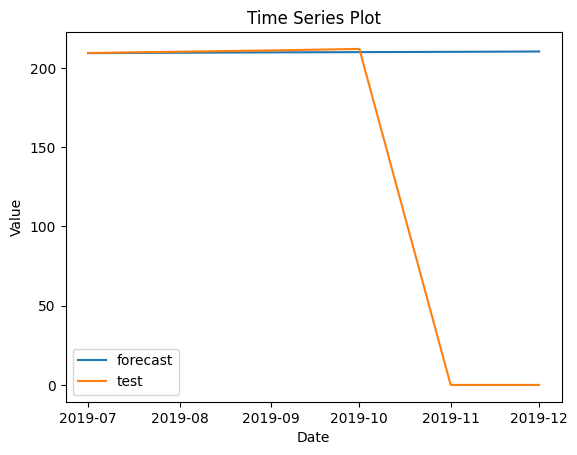

In [16]:
# point forecasts dataframe
forecasts_df = prediction.forecast
plt.plot(forecasts_df.index, forecasts_df['CSUSHPISA'], label='forecast')
plt.plot(df_test.index, df_test['CSUSHPISA'], label='test')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [18]:
model.best_model_name
# ,
# model.best_model_params,
# model.best_model_transformation_params

'Ensemble'

### Accuracy metrics

In [11]:
def forecast_accuracy(forecast, actual):
    forecast,actual= np.array(forecast), np.array(actual) 
    try:
        mape = np.mean(np.abs((actual - forecast) / actual))*100
    except:
        mape = 200 # MAPE
    mae = mean_absolute_error(actual,forecast)    # MAE
    rmse = (mean_squared_error(actual,forecast))**.5  # RMSE
#     MASE=mase(actual,forecast)
    r2=r2_score(actual,forecast)                   # r-squared
    rtae=(mean_absolute_error(actual,forecast)/np.mean(abs(actual)))
    return({'mape':mape, 'mae': mae, 
            'rmse':rmse,
             'r2':r2,
            'rtae':rtae
           })

### multi collinearity 

In [35]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
X = data[['variable1', 'variable2', 'variable3', ...]]
corr_matrix = X.corr()
print(corr_matrix)  

In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in
 
range(X.shape[1])]
vif["Feature"] = X.columns
print(vif)  # Look for VIF values above 5 or 10

### co integration

In [28]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

In [29]:
res=coint_johansen(df_train.values,det_order=1,k_ar_diff=1)

In [32]:
print(res.lr1)

[391.85900721 205.79517096 126.00846703  89.23417867  58.29375911
  38.44314963  20.63957279  10.05434181   4.11609295]


In [34]:
print(res.lr2)
print(res.evec)

[186.06383625  79.78670393  36.77428835  30.94041957  19.85060947
  17.80357684  10.58523099   5.93824885   4.11609295]
[[ 1.97241978e-02 -5.01741614e-03  1.63279211e-02 -2.67821419e-02
  -3.52942959e-03  1.72451232e-03  5.26293393e-02  1.85990188e-02
   3.48338342e-02]
 [-2.50346654e-01 -5.64425043e-02  1.66826388e-02  3.12489638e-02
   1.00873588e-02  9.04124510e-03  4.88996620e-03 -8.93665961e-03
  -1.14016136e-02]
 [ 6.29570945e-01 -1.45593807e-01 -1.51508034e+00  1.31295924e+00
  -1.19155834e+00 -2.69519399e+00  3.33664930e+00  8.06773596e-01
  -1.65935282e+00]
 [ 3.31946241e-01  3.59050736e-03 -3.41450748e-01  1.00029341e-01
   2.80375825e-01  1.35099069e-01 -1.66898474e-01 -6.48570386e-01
  -6.74020932e-02]
 [ 1.23976972e+00  1.86375582e+00  2.81435816e+00 -1.80729134e+00
   2.49838668e+00 -1.76304499e+00  6.59365108e-02 -5.81907874e-01
  -2.26704748e+00]
 [ 3.19575743e-02 -8.16969649e-02  7.63322468e-02 -5.68766438e-01
   2.01120111e-01  3.09238454e-01  1.39694625e-01 -5.491272